In [91]:
import pandas as pd
from matplotlib import pyplot as plt
import random
import numpy as np
import math
import importlib
import mcmc_functions
importlib.reload(mcmc_functions)

from mcmc_functions import *
import importlib

seasons_missing_df = pd.read_csv('/Users/josephsun/Desktop/M4R/code/premier-league-matches.csv')
tables_df = pd.read_csv('/Users/josephsun/Desktop/M4R/code/pl-tables-1993-2024.csv')
recent_df = pd.read_csv('matches.csv')
recent_df = recent_df[recent_df['Venue'] == 'Home']

converted_recent_df = convert_match_data(recent_df)
converted_recent_df = converted_recent_df.sort_values(by='Wk').reset_index(drop=True)

seasons_df = pd.concat([seasons_missing_df, converted_recent_df], ignore_index=True)

In [51]:
twenty_two_season = seasons_df[seasons_df['Season_End_Year'] == 2022]
twenty_three_season = seasons_df[seasons_df['Season_End_Year'] == 2023]

In [80]:
lambda_h = np.mean([twenty_two_season['HomeGoals'].mean(), twenty_three_season['HomeGoals'].mean()])
lambda_a = np.mean([twenty_two_season['AwayGoals'].mean(), twenty_three_season['AwayGoals'].mean()])

synthetic_mu_p = 0
synthetic_sigma_p = 0.1
synthetic_eta = 1
synthetic_sigma_s = 0.1

print(f'Average Home Goals: {lambda_h}')
print(f'Average Away Goals: {lambda_a}')

synthetic_params = {
    'Home Advantage': lambda_h,
    'Away Advantage': lambda_a, 
    'Eta': synthetic_eta,
    'Sigma_S': synthetic_sigma_s,
    'Mu_P': synthetic_mu_p,
    'Sigma_P': synthetic_sigma_p
}

Average Home Goals: 1.5736842105263158
Average Away Goals: 1.2618421052631579


In [53]:
joined_twenty_two, twenty_two_strengths = sample_initial_strengths(twenty_two_season)
twenty_two_s = add_scores(joined_twenty_two, lambda_h, lambda_a)

twenty_three_teams = sorted(twenty_three_season['Home'][:100].unique())
joined_twenty_three, twenty_three_strengths = sample_prior_strengths(twenty_three_season, twenty_two_strengths, twenty_three_teams, 
                                                                     mu_p = synthetic_mu_p, sigma_p = synthetic_sigma_p,
                                                                     eta = synthetic_eta, sigma_s = synthetic_sigma_s)
twenty_three_s = add_scores(joined_twenty_three, lambda_h, lambda_a)

synthetic_seasons = pd.concat([twenty_two_s, twenty_three_s], ignore_index=True)


In [54]:
joined_twenty_three

,Season_End_Year,Wk,Date,Home,HomeGoals,AwayGoals,Away,FTR,Team Name_x,HomeStrength,Team Name_y,AwayStrength,Sampled Score,LogLikelihood
0,2023,1,2022-08-05,Crystal Palace,0,2,Arsenal,A,Crystal Palace,0.095420,Arsenal,0.121946,"[1, 1]",-2.142259
1,2023,1,2022-08-06,Fulham,2,2,Liverpool,D,Fulham,-0.016359,Liverpool,-0.042655,"[0, 1]",-2.638431
2,2023,1,2022-08-06,Tottenham,4,1,Southampton,H,Tottenham,0.051307,Southampton,0.023560,"[0, 2]",-3.128767
3,2023,1,2022-08-06,Newcastle Utd,2,0,Nott'ham Forest,H,Newcastle Utd,-0.061863,Nott'ham Forest,-0.015149,"[0, 0]",-2.824048
4,2023,1,2022-08-06,Leeds United,2,1,Wolves,H,Leeds United,0.224400,Wolves,0.176056,"[3, 2]",-3.465081
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
375,2023,38,2023-05-28,Everton,1,0,Bournemouth,H,Everton,-0.062041,Bournemouth,0.029995,"[0, 0]",-2.818803
376,2023,38,2023-05-28,Leicester City,2,1,West Ham,H,Leicester City,-0.065100,West Ham,-0.080870,"[3, 2]",-3.484530
377,2023,38,2023-05-28,Aston Villa,2,1,Brighton,H,Aston Villa,-0.124170,Brighton,-0.014195,"[1, 1]",-2.132335
378,2023,38,2023-05-28,Leeds United,1,4,Tottenham,A,Leeds United,0.224400,Tottenham,0.051307,"[1, 0]",-2.305845


In [55]:
synthetic_seasons[['HomeGoals', 'AwayGoals']] = pd.DataFrame(
    synthetic_seasons['Sampled Score'].tolist(),
    index=synthetic_seasons.index
)

# Select only the desired columns
synthetic_seasons = synthetic_seasons[
    ['Season_End_Year', 'Wk', 'Date', 'Home', 'HomeGoals', 'AwayGoals', 'Away', 'FTR']
]

In [69]:
compute_league_table(synthetic_seasons[synthetic_seasons['Season_End_Year'] == 2023])

/Users/josephsun/Desktop/M4R/code/mcmc_functions.py:1099: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  ]).fillna(0)


,Team,MP,W,D,L,GF,GA,GD,PTS
0,Leeds United,38,30,5,3,84,32,52,95
1,Wolves,38,20,11,7,65,41,24,71
2,Arsenal,38,20,7,11,74,55,19,67
3,Fulham,38,17,9,12,56,56,0,60
4,Crystal Palace,38,16,10,12,62,51,11,58
5,Bournemouth,38,15,13,10,52,50,2,58
6,Brentford,38,16,7,15,54,52,2,55
7,Brighton,38,14,9,15,57,60,-3,51
8,Nott'ham Forest,38,12,14,12,58,51,7,50
9,Manchester Utd,38,13,10,15,54,48,6,49


In [64]:
strength_dict, parameters, acceptance_counters, tracked_parameters, strength_dict_original, parameters_original = (
mcmc(synthetic_seasons, 2022, 2023, burn_in = 50000, iterations = 50000))

In [65]:
acceptance_counters

{'Strength': {'accepted': 25700, 'total': 40144},
 'Home Advantage': {'accepted': 6,
  'total': 2454,
  'percentage': 0.24449877750611246},
 'Away Advantage': {'accepted': 249,
  'total': 2538,
  'percentage': 9.810874704491725},
 'Mu_P': {'accepted': 0, 'total': 2395, 'percentage': 0.0},
 'Sigma_P': {'accepted': 0, 'total': 2395, 'percentage': 0.0},
 'Eta': {'accepted': 72, 'total': 2469, 'percentage': 2.916160388821385},
 'Sigma_S': {'accepted': 72, 'total': 2469, 'percentage': 2.916160388821385}}

/Users/josephsun/Desktop/M4R/code/mcmc_functions.py:715: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  joined_df['Strength History'] = joined_df.values.tolist()


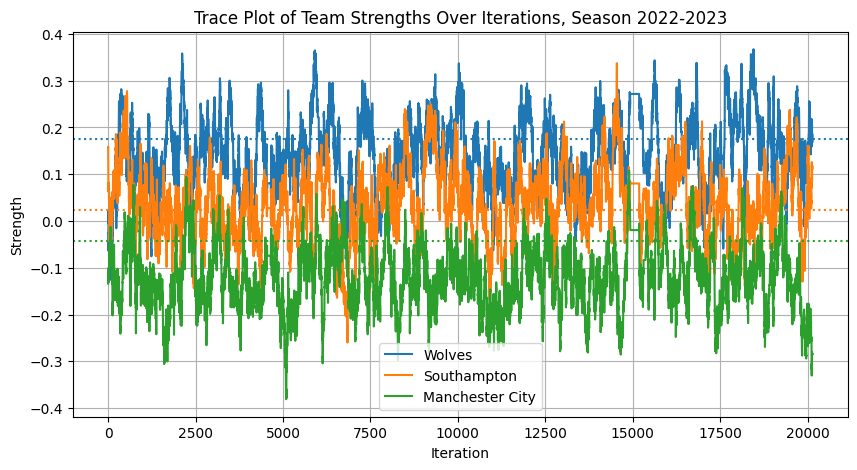

In [89]:
trace_plot_strength(strength_dict, ['Wolves', 'Southampton', 'Manchester City'], 2023, true_strengths = twenty_three_strengths)

/Users/josephsun/Desktop/M4R/code/mcmc_functions.py:715: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  joined_df['Strength History'] = joined_df.values.tolist()
/Users/josephsun/Desktop/M4R/code/mcmc_functions.py:715: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  joined_df['Strength History'] = joined_df.values.tolist()


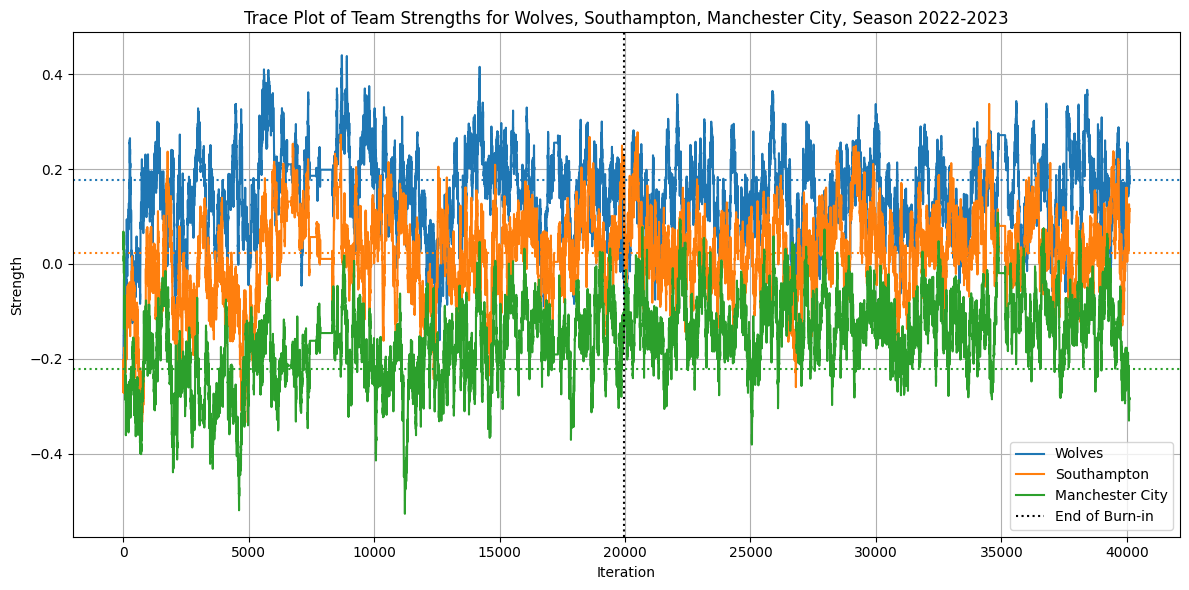

In [92]:
trace_plot_strength_with_burnin(strength_dict, strength_dict_original, ['Wolves', 'Southampton', 'Manchester City'], 2023, true_strengths = twenty_three_strengths)

In [81]:
def trace_plot_parameter_with_burnin(parameter_dict, parameter_dict_original, true_values=False):
    """
    Trace plots of scalar parameters showing both burn-in and post-burn-in samples.

    Parameters:
    - parameter_dict: dict of post-burn-in samples
    - parameter_dict_original: dict of full MCMC samples (including burn-in)
    - true_values: dict of true values (optional); if provided, horizontal lines are drawn
    """
    title_dict = {
        'Home Advantage': r'$\lambda_H$',
        'Away Advantage': r'$\lambda_A$',
        'Eta': r'$\eta$',
        'Sigma_S': r'$\sigma_s$',
        'Mu_P': r'$\mu_p$',
        'Sigma_P': r'$\sigma_p$'
    }

    num_params = len(parameter_dict)
    fig, axes = plt.subplots(3, 2, figsize=(12, 12))
    axes = axes.flatten()

    for ax, (parameter, post_values) in zip(axes, parameter_dict.items()):
        full_values = parameter_dict_original[parameter]
        burn_in = len(full_values) - len(post_values)

        # Plot full trace
        ax.plot(full_values, color='blue', label='Trace')

        # Highlight post-burn-in
        ax.plot(range(burn_in, len(full_values)), post_values, color='blue')

        # Vertical line for burn-in
        ax.axvline(x=burn_in, color='black', linestyle='dotted', label='End of Burn-in')

        # Add horizontal line for true value if provided
        if true_values and parameter in true_values:
            ax.axhline(y=true_values[parameter], color='red', linestyle='dashed', label='True value')

        label = title_dict.get(parameter, parameter)
        ax.set_title(f"Trace Plot of {label}")
        ax.set_xlabel("Iteration")
        ax.set_ylabel("Value")
        ax.grid(True)
        ax.legend()

    for i in range(num_params, len(axes)):
        axes[i].axis("off")

    plt.tight_layout()
    plt.show()


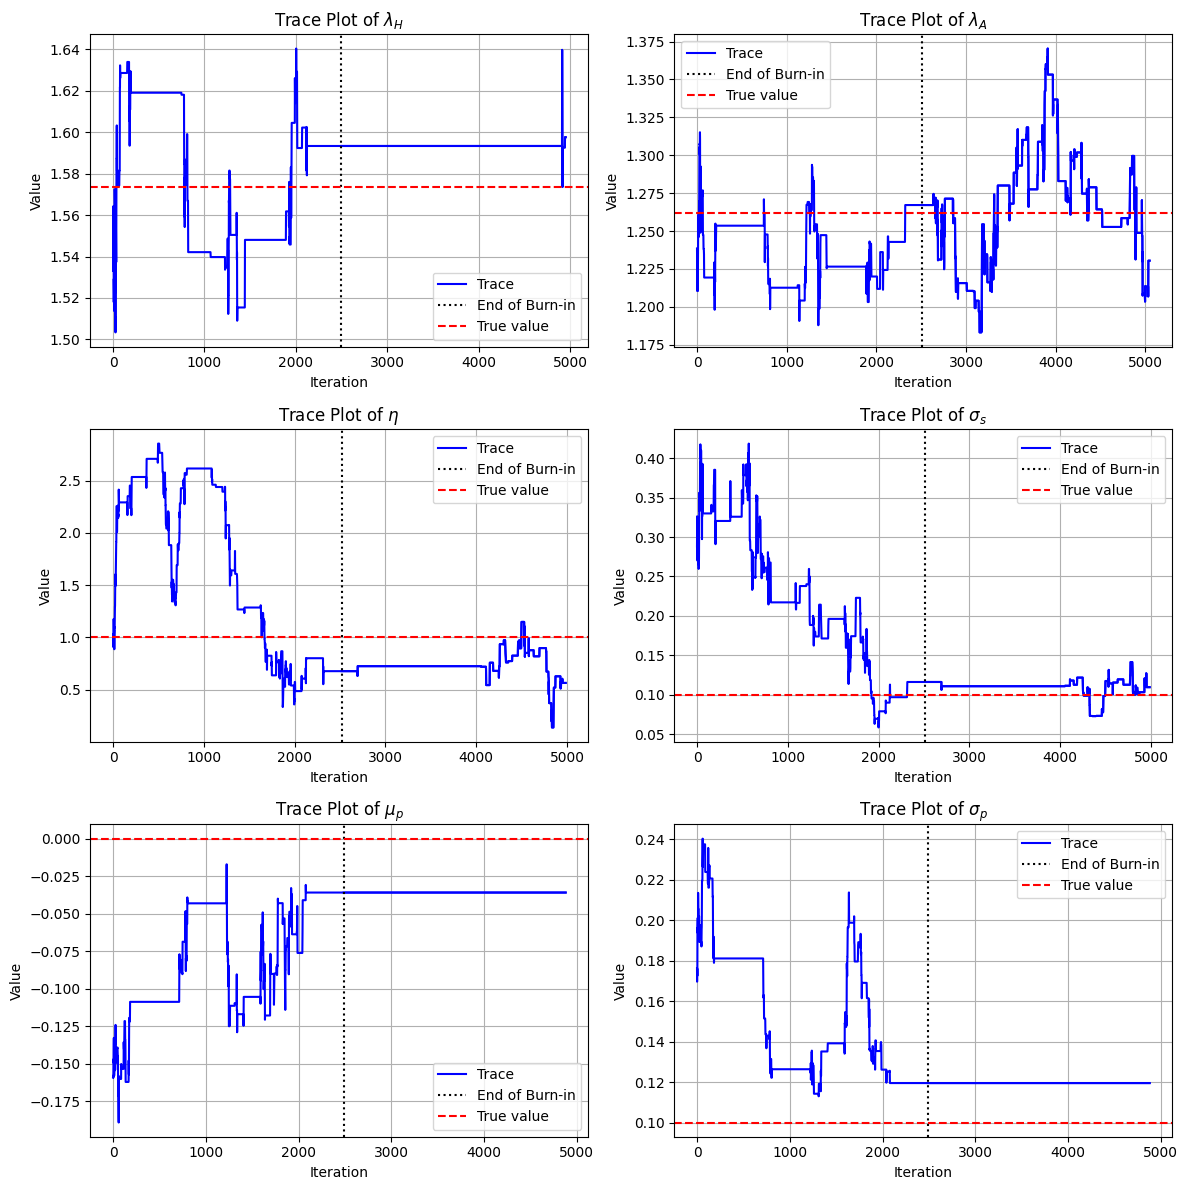

In [82]:
trace_plot_parameter_with_burnin(parameters, parameters_original, synthetic_params)

Changed Version
